In [1]:
import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import BertForSequenceClassification, BertTokenizer, BertConfig
from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig
from transformers import XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig
from transformers import XLMForSequenceClassification, XLMTokenizer, XLMConfig
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig
from transformers import AutoModelForSequenceClassification, AutoTokenizer, AutoConfig

In [2]:
import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)
print('pytorch version : ', torch.__version__)

fastai version : 1.0.57
transformers version : 2.5.1
pytorch version :  1.3.1+cpu


In [3]:
train = pd.read_csv('train.csv')
valid = pd.read_csv('valid.csv')

In [4]:
train.head()

,Unnamed: 0,text,lang
0,19306,1.01 prithviraj anenn manasilayavar like adik,4
1,13031,rajani sir gr8 man agree hit like,3
2,3135,it also features motion blur unlike its predec...,1
3,1767,petta vs viswasam petta like viswasam comment,3
4,7086,but even then yaar real identity toh connect k...,2


In [5]:
MODEL_CLASSES = {
    'bert': (BertForSequenceClassification, BertTokenizer, BertConfig),
    'xlnet': (XLNetForSequenceClassification, XLNetTokenizer, XLNetConfig),
    'xlm': (XLMForSequenceClassification, XLMTokenizer, XLMConfig),
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
    'distilbert': (DistilBertForSequenceClassification, DistilBertTokenizer, DistilBertConfig),
    'auto': (AutoModelForSequenceClassification, AutoTokenizer, AutoConfig)
}


In [6]:
seed = 42
use_fp16 = False
bs = 16

model_type = 'auto'
pretrained_model_name = 'ai4bharat/indic-bert'


In [7]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]


In [8]:
# model_class.pretrained_model_archive_map.keys()


In [9]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False


In [10]:
seed_all(seed)


In [11]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        else:
            tokens = self._pretrained_tokenizer.tokenize(t)[:self.max_seq_len - 2]
            if self.model_type in ['xlnet']:
                tokens = tokens + [SEP] +  [CLS]
            else:
                tokens = [CLS] + tokens + [SEP]
        return tokens


In [12]:
transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])


In [13]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)
        #return self.tokenizer.encode(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})


In [14]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]


In [15]:
pad_idx = transformer_tokenizer.pad_token_id


In [16]:
tokens = transformer_tokenizer.tokenize('Salut c est moi, Hello it s me')
print(tokens)
ids = transformer_tokenizer.convert_tokens_to_ids(tokens)
print(ids)
transformer_tokenizer.convert_ids_to_tokens(ids)


['▁sal', 'ut', '▁c', '▁est', '▁mo', 'i', ',', '▁he', 'llo', '▁it', '▁s', '▁me']
[35965, 23871, 6364, 98756, 34458, 782, 12, 193, 88345, 145, 98, 1613]


['▁sal', 'ut', '▁c', '▁est', '▁mo', 'i', ',', '▁he', 'llo', '▁it', '▁s', '▁me']

In [17]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'lang')
             .add_test(valid)
             .databunch(bs=bs, pad_first=False, pad_idx=transformer_tokenizer.pad_token_id))


/home/tathagata.raha/anaconda/envs/p37/lib/python3.7/site-packages/fastai/core.py:299: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(a, dtype=dtype, **kwargs)


/home/tathagata.raha/anaconda/envs/p37/lib/python3.7/site-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [18]:
print('[CLS] token :', transformer_tokenizer.cls_token)
print('[SEP] token :', transformer_tokenizer.sep_token)
print('[PAD] token :', transformer_tokenizer.pad_token)
databunch.show_batch()


[CLS] token : [CLS]
[SEP] token : [SEP]
[PAD] token : <pad>


text,target
[CLS] ▁ iam ▁chit tti ▁re lod ed ▁version ▁2. o ▁s ema ▁mass s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s s,3
[CLS] ▁mam mo kka ▁en num ▁or u ▁ lah ariya anu . annum ▁en num ▁a th bud apped utt iy itte y ▁u llu . ▁pad am ▁or u ▁ vam bhan ▁hit tak um .. m inimum ▁250 cr ▁k adak kum .. look am ▁va ay th um ▁mam mo tty ▁ enna [SEP] <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,4
[CLS] ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya ▁ ner aya [SEP] <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,3
[CLS] ▁mo hal ▁lal ▁a a ▁film il ▁t hov in one ▁ka an un ne ▁pol um ▁ illa a ... a a ▁film il ▁ mohan lal in de ▁an iyan aan h ... yen dh ▁an iyan ... pr rr rr ... ka an un ne ▁pool um ▁ illa a [SEP] <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,4
[CLS] ▁ thala iver ▁ep p av um ▁mass s ▁than n .. p etta ila ▁in num ▁mass s ... t q ▁ka arth ik ▁sub bu raj ▁sir ... mun na di ▁i run tha ▁tha lai var ▁style ▁la ▁mar up a dium ▁ kon du ▁v antha th uku ... [SEP] <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad> <pad>,3


In [19]:
print('[CLS] id :', transformer_tokenizer.cls_token_id)
print('[SEP] id :', transformer_tokenizer.sep_token_id)
print('[PAD] id :', pad_idx)
test_one_batch = databunch.one_batch()[0]
print('Batch shape : ',test_one_batch.shape)
print(test_one_batch)


[CLS] id : 2
[SEP] id : 3
[PAD] id : 0
Batch shape :  torch.Size([16, 353])
tensor([[     2,      8, 164647,  ..., 102114,    818,      3],
        [     2, 132906,    782,  ...,      0,      0,      0],
        [     2,   1848, 110252,  ...,      0,      0,      0],
        ...,
        [     2,  27889,  43982,  ...,      0,      0,      0],
        [     2,  24659,  29756,  ...,      0,      0,      0],
        [     2,  16726, 166711,  ...,      0,      0,      0]])


/home/tathagata.raha/anaconda/envs/p37/lib/python3.7/site-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [23]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        self.pad_idx = AutoTokenizer.from_pretrained('ai4bharat/indic-bert').pad_token_id
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=self.pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits


In [24]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 5
config.use_bfloat16 = use_fp16
print(config)


AlbertConfig {
  "architectures": null,
  "attention_probs_dropout_prob": 0,
  "bos_token_id": null,
  "classifier_dropout_prob": 0.1,
  "do_sample": false,
  "down_scale_factor": 1,
  "embedding_size": 128,
  "eos_token_ids": null,
  "finetuning_task": null,
  "gap_size": 0,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1"
  },
  "initializer_range": 0.02,
  "inner_group_num": 1,
  "intermediate_size": 3072,
  "is_decoder": false,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1
  },
  "layer_norm_eps": 1e-12,
  "length_penalty": 1.0,
  "max_length": 20,
  "max_position_embeddings": 512,
  "model_type": "albert",
  "net_structure_type": 0,
  "num_attention_heads": 12,
  "num_beams": 1,
  "num_hidden_groups": 1,
  "num_hidden_layers": 12,
  "num_labels": 5,
  "num_memory_blocks": 0,
  "num_return_sequences": 1,
  "output_attentions": false,
  "output_hidden_states": false,
  "output_past": true,
  "pad_to

In [25]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)
# transformer_model = model_class.from_pretrained(pretrained_model_name, num_labels = 5)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)


In [26]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()


In [27]:
list_layers = [learner.model.transformer.albert.embeddings,
              learner.model.transformer.albert.encoder.albert_layer_groups[0].albert_layers[0],
              learner.model.transformer.albert.pooler]


In [28]:
# learner.model.transformer

In [29]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')


Learner split in 3 groups


In [30]:
learner.save('indic-untrain')


In [31]:
seed_all(seed)
learner.load('indic-untrain');


In [32]:
learner.freeze_to(-1)


In [33]:
learner.lr_find()


epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 2.09E-03
Min loss divided by 10: 3.63E-04


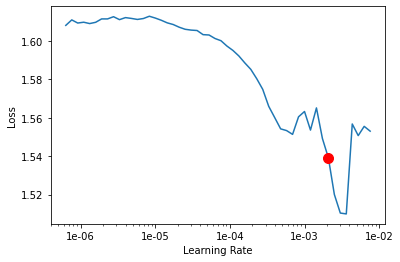

In [34]:
learner.recorder.plot(skip_end=10,suggestion=True)


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.543166,0.547970,0.744097,0.255903,03:07


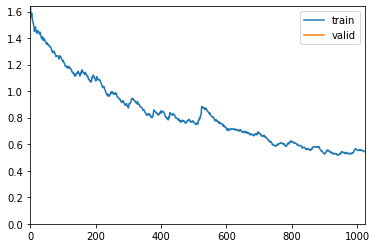

In [35]:
learner.fit_one_cycle(1,max_lr=5e-03,moms=(0.8,0.7))


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.238666,0.247407,0.908841,0.091159,09:07


/home/tathagata.raha/anaconda/envs/p37/lib/python3.7/site-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


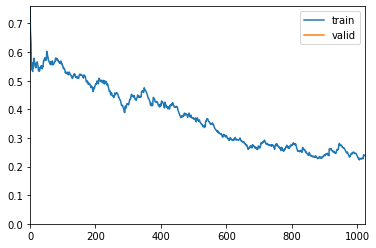

In [36]:
seed_all(seed)
learner.freeze_to(-2)
lr = 1e-5

learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))


In [37]:
# seed_all(seed)
# learner.freeze_to(-3)
# learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.208072,0.169883,0.933553,0.066447,10:15
1,0.071571,0.141390,0.953322,0.046678,10:19


/home/tathagata.raha/anaconda/envs/p37/lib/python3.7/site-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


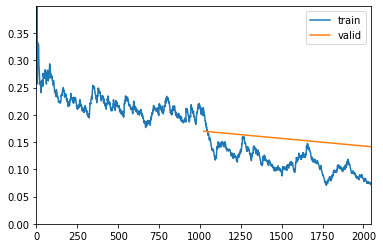

/home/tathagata.raha/anaconda/envs/p37/lib/python3.7/site-packages/fastai/text/data.py:124: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sort_idx = np.concatenate(np.random.permutation(ck_idx[1:])) if len(ck_idx) > 1 else np.array([],dtype=np.int)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [38]:
seed_all(seed)
learner.unfreeze()
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))


In [43]:
# learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr), moms=(0.8, 0.9))

In [41]:
learner.predict("The model was trained on code-mixed data.")

(Category 1,
 tensor(0),
 tensor([9.9933e-01, 4.2520e-06, 6.5768e-04, 8.6929e-06, 2.5208e-09]))

In [44]:
learner.export(file = 'models/export.pkl');

In [39]:
output[0]

Category 1

In [57]:
from fastai.basic_train import load_learner
tmp = load_learner(path='models', file='export.pkl')

In [58]:
tmp.predict("Naa introvert da enneye yenda pese vekkiringe")

(Category 3,
 tensor(2),
 tensor([1.6516e-04, 1.9224e-02, 9.6742e-01, 1.3188e-02, 6.0965e-09]))